# quantum-convolutional-neural-network



In [1]:
#import dependencies 
import tensorflow as tf
import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import pandas as pd
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow_quantum as tfq

In [2]:
# load data mnist
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
#normalising
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

In [4]:
#function for filter data number 3 dan number 6 
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [5]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


In [6]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

In [7]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [8]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


In [9]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [10]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

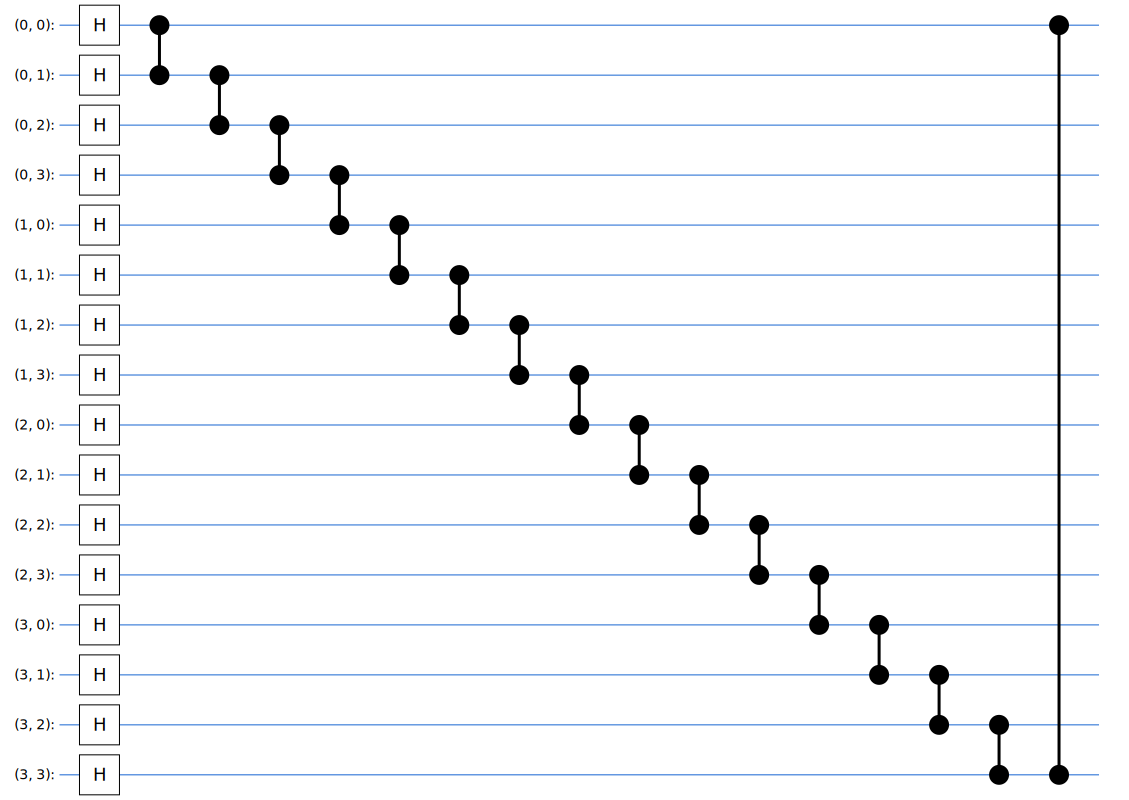

In [11]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(4, 4)))

In [12]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

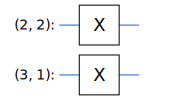

In [13]:
SVGCircuit(x_train_circ[0])

In [14]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

In [15]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [16]:
x_train_tfcirc.shape , x_test_tfcirc.shape

(TensorShape([10338]), TensorShape([1968]))

In [17]:
y_train_nocon.shape, len(y_test)

((10338,), 1968)

In [18]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

# BUILD MODEL

In [19]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])
    

    
def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

In [20]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit



def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit
  
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)



## Create Model Rebuild QCNN + CNN

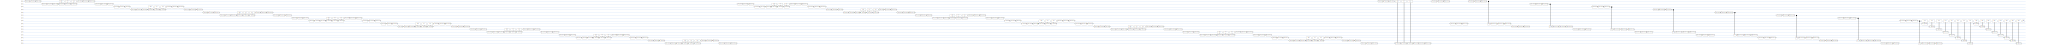

In [21]:
qubits = cirq.GridQubit.rect(4, 4)
readout = cirq.GridQubit(1,2)
circuit = cirq.Circuit()


symbols = sympy.symbols('qconv0:84')
circuit += quantum_conv_circuit(qubits , symbols[0:15]) # range symbols always 16
circuit += quantum_pool_circuit(qubits[:8], qubits[8:], symbols[15:21])


readout_qnn = cirq.GridQubit(1, 3)
data_qubits_qnn = cirq.GridQubit.rect(4, 4)[8:]

builder = CircuitLayerBuilder( data_qubits = data_qubits_qnn, readout=readout_qnn)

# Then add layers (experiment by adding more).
builder.add_layer(circuit, cirq.XX, "xx1")
builder.add_layer(circuit, cirq.ZZ, "zz1")

model_readout = circuit.append(cirq.H(cirq.GridQubit(1, 3)))

SVGCircuit(circuit)


In [22]:
readout_operators = cirq.Z(qubits[-1])

excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(qubits))

quantum_model = tfq.layers.PQC(circuit,
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

## Training Model

In [23]:
len(y_train_hinge), x_train_tfcirc.shape

(10338, TensorShape([10338]))

In [24]:
len(y_test_hinge), x_test_tfcirc.shape

(1968, TensorShape([1968]))

In [25]:
epochs = 10
BATCH_SIZE = 32
NUM_EXAMPLES = 5


In [26]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_train_tfcirc_sub.shape , y_train_hinge_sub.shape

(TensorShape([5]), (5,))

In [27]:
import collections, numpy
collections.Counter(y_train_hinge_sub)

Counter({1.0: 3, -1.0: 2})

In [28]:


# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)
    return tf.reduce_mean(result)


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[hinge_accuracy])

history = qcnn_model.fit(x=x_train_tfcirc_sub,
                         y=y_train_hinge_sub,
                         batch_size=16,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(x_test_tfcirc , y_test_hinge))

Train on 5 samples, validate on 1968 samples
Epoch 1/10
5/5 [==============================] - 47s 9s/sample - loss: 1.0140 - hinge_accuracy: 0.4000 - val_loss: 1.0003 - val_hinge_accuracy: 0.5163
Epoch 2/10
5/5 [==============================] - 38s 8s/sample - loss: 0.9898 - hinge_accuracy: 0.6000 - val_loss: 1.0054 - val_hinge_accuracy: 0.5163
Epoch 3/10
5/5 [==============================] - 38s 8s/sample - loss: 0.9730 - hinge_accuracy: 0.6000 - val_loss: 1.0273 - val_hinge_accuracy: 0.5163
Epoch 4/10
5/5 [==============================] - 41s 8s/sample - loss: 0.9622 - hinge_accuracy: 0.6000 - val_loss: 1.0545 - val_hinge_accuracy: 0.5163
Epoch 5/10
5/5 [==============================] - 41s 8s/sample - loss: 0.9649 - hinge_accuracy: 0.6000 - val_loss: 1.0637 - val_hinge_accuracy: 0.5163
Epoch 6/10
5/5 [==============================] - 39s 8s/sample - loss: 0.9675 - hinge_accuracy: 0.6000 - val_loss: 1.0585 - val_hinge_accuracy: 0.5163
Epoch 7/10
5/5 [===========================

## Save Result

In [29]:
history.history
df_history = pd.DataFrame()
df_history['accuracy']  = history.history['hinge_accuracy']
df_history['loss']      = history.history['loss']
df_history['val_accuracy'] = history.history['val_hinge_accuracy']
df_history['val_loss']  = history.history['val_loss']

df_history.to_csv("history.csv", index = False)

print(df_history.shape)
df_history.head()

(10, 4)


,accuracy,loss,val_accuracy,val_loss
0,0.4,1.013969,0.51626,1.000279
1,0.6,0.989797,0.51626,1.005416
2,0.6,0.973022,0.51626,1.027310
3,0.6,0.962180,0.51626,1.054475
4,0.6,0.964911,0.51626,1.063738


In [30]:
def plt_losses(x, vy, ty, ax, colors=['b']):
  ax.plot(x, vy, 'b', label="Validation Loss")
  ax.plot(x, ty, 'r', label="Train Loss")
  plt.legend()
  plt.grid()
  fig.canvas.draw()

def plt_accuracies(x, vy, ty, ax, colors=['b']):
  ax.plot(x, vy, 'b', label="Validation accuracy")
  ax.plot(x, ty, 'r', label="Train accuracy")
  plt.legend() 
  plt.grid()
  fig.canvas.draw()



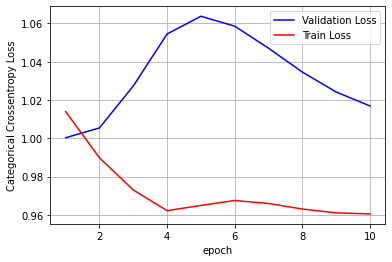

In [31]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_losses(x, vy, ty, ax)

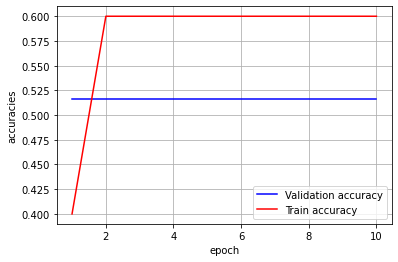

In [32]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracies')
x = list(range(1,epochs+1))
vy = history.history['val_hinge_accuracy']
ty = history.history['hinge_accuracy']
plt_accuracies(x, vy, ty, ax)